In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'D:\Stock_trend_project\data\interim\train_clean_after_2010_and_bad_tickers.csv')



توزيع الأسعار عبر جميع الأسهم

توزيع أسعار الأسهم عبر جميع الأسطر وجميع الأسهم في الداتاسيت.
الهدف هو فهم:
- نطاق الأسعار (Minimum, Maximum).
- أماكن تركز القيم (Where most prices lie).
- وجود أي قيم شاذة أو ذيول طويلة في التوزيع (Outliers, Long Tails).

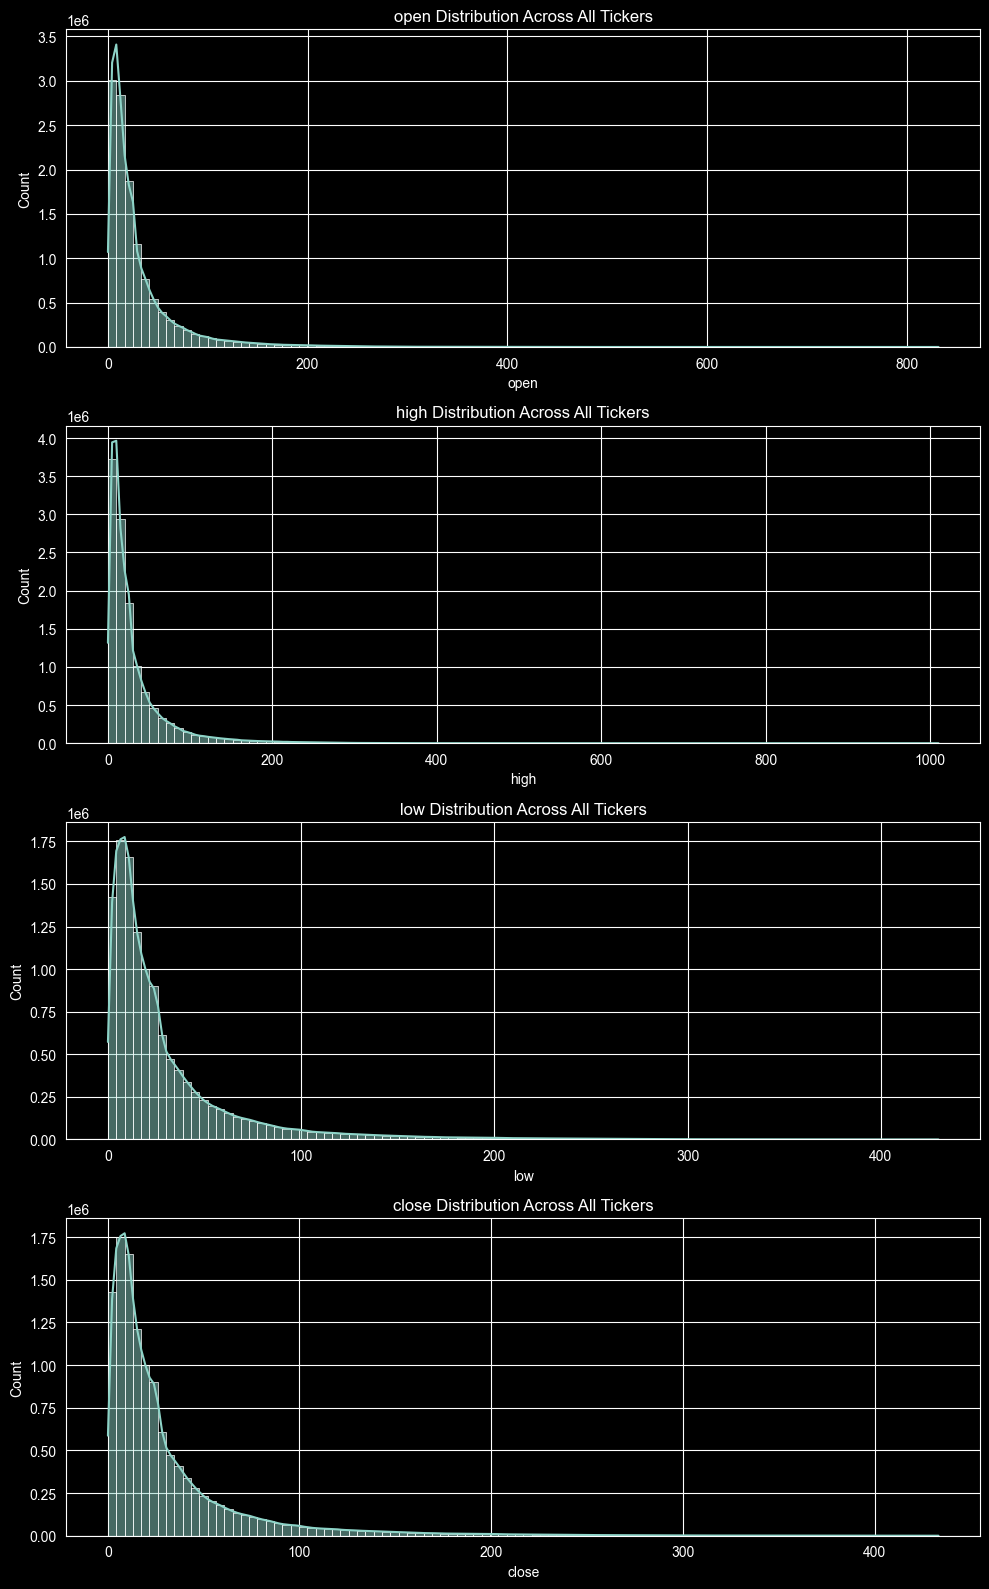

In [2]:


price_cols = ["open", "high", "low", "close"]

fig, axes = plt.subplots(len(price_cols), 1, figsize=(10, 4*len(price_cols)))

for i, col in enumerate(price_cols):
    ax = axes[i]
    sns.histplot(
        data=df,
        x=col,
        bins=100,
        kde=True,
        ax=ax
    )
    ax.set_title(f"{col} Distribution Across All Tickers")
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()


Continuous Variables Analysis

Price distributions across all companies

This code reshapes the Open, High, Low, and Close columns into a long format and then plots a stacked histogram of the raw price values, colored by price type, to show how each type of price is distributed across all records and companies in the dataset.

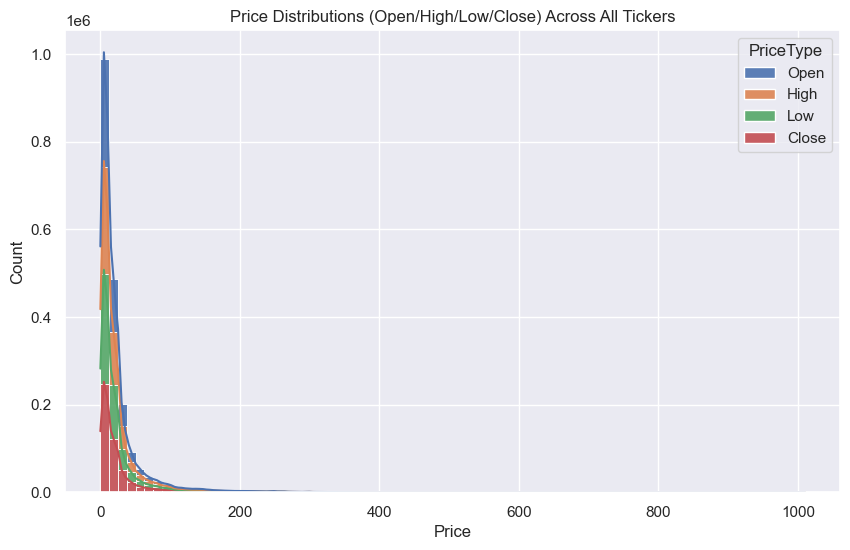

In [14]:

prices_long = df.melt(
    value_vars=price_cols,
    var_name="PriceType",
    value_name="Price"
)

plt.figure(figsize=(10, 6))
sns.histplot(
    data=prices_long,
    x="Price",
    hue="PriceType",
    bins=80,
    kde=True,
    multiple="stack",
    alpha=0.9,
)

plt.title("Price Distributions (Open/High/Low/Close) Across All Tickers")
plt.xlabel("Price")
plt.ylabel("Count")

plt.show()



## Extreme stock prices and outliers

In this section, I:
- Compute the global minimum and maximum prices across Open/High/Low/Close.
- Identify which tickers and dates correspond to these extreme price values.
- Visualize price outliers using a boxplot to see if there are unusually high or low prices that may need special handling in the model.


Global min price: 0.0
Global max price: 1010.0800170898438

Rows with global MAX price:


,ticker,date,open,high,low,close
10090635,ticker_4784,2022-09-01,831.919983,1010.080017,328.0,419.200012



Rows with global MIN price:


,ticker,date,open,high,low,close
9784488,ticker_4468,2021-09-29,130.0,140.399994,0.0,140.399994


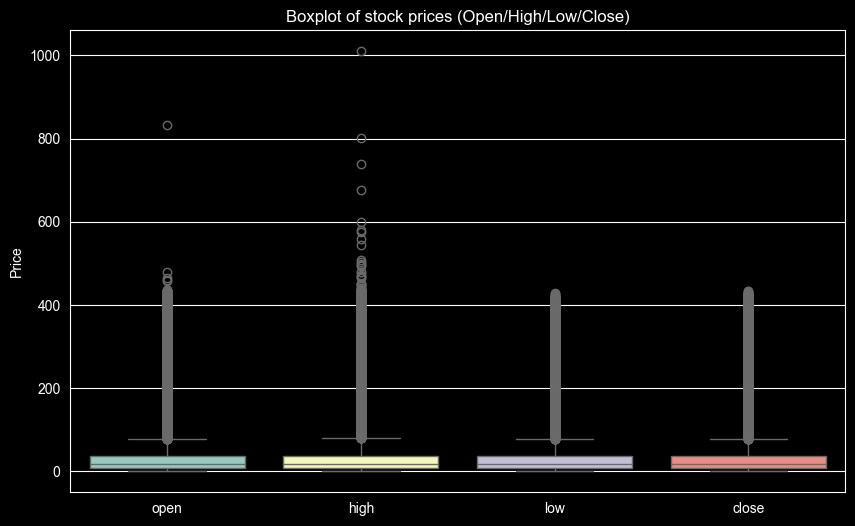

In [4]:

price_cols = ["open", "high", "low", "close"]

global_min = df[price_cols].min().min()
global_max = df[price_cols].max().max()

print("Global min price:", global_min)
print("Global max price:", global_max)

high_price_mask = df[price_cols].max(axis=1) == global_max
low_price_mask  = df[price_cols].min(axis=1) == global_min

high_price_rows = df.loc[high_price_mask, ["ticker", "date"] + price_cols]
low_price_rows  = df.loc[low_price_mask,  ["ticker", "date"] + price_cols]

print("\nRows with global MAX price:")
display(high_price_rows.head())

print("\nRows with global MIN price:")
display(low_price_rows.head())

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[price_cols])
plt.title("Boxplot of stock prices (Open/High/Low/Close)")
plt.ylabel("Price")
plt.show()

## Volume distribution and outliers

In this section:
- I analyze the distribution of trading volume using a **log-transformed** histogram `log(1 + Volume)` to handle the strong right skew.
- I use a **boxplot** on the raw `Volume` values to visually highlight extreme trading days.
- I compute IQR-based bounds to **count and inspect Volume outliers**, which may require special treatment before training the model.


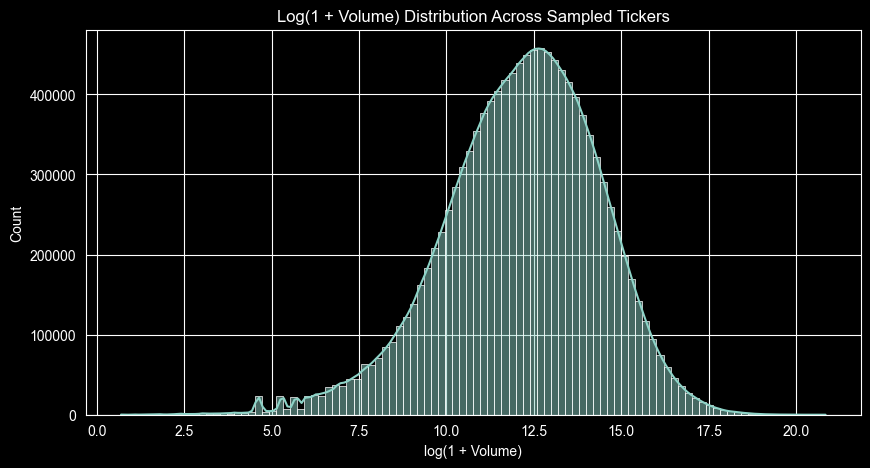

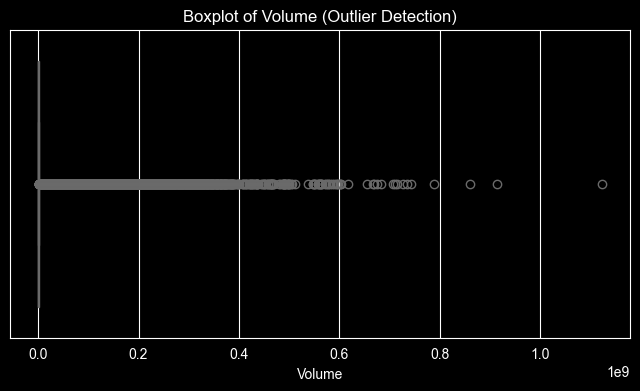

IQR-based Volume outliers count: 1005698


,ticker,date,open,high,low,close,volume,dividends,stock_splits,return,return_is_outlier
13,ticker_1,2010-01-22,27.320733,27.595038,26.449054,26.522202,6468200.0,0.0,0.0,-0.046042,True
23,ticker_1,2010-02-05,26.235714,26.363722,25.912642,26.321053,3735600.0,0.0,0.0,0.003719,False
85,ticker_1,2010-05-06,27.807619,27.875607,26.083163,27.325512,3747300.0,0.0,0.0,-0.018646,False
86,ticker_1,2010-05-07,27.739629,27.807619,27.084459,27.405863,4685400.0,0.0,0.0,0.002941,False
95,ticker_1,2010-05-20,27.145879,27.446595,26.914076,26.914076,3670500.0,0.0,0.0,-0.019626,False


In [3]:

plt.figure(figsize=(10, 5))
sns.histplot(
    x=np.log1p(df["volume"]),
    bins=100,
    kde=True
)
plt.title("Log(1 + Volume) Distribution Across Sampled Tickers")
plt.xlabel("log(1 + Volume)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(
    x=df["volume"]
)
plt.title("Boxplot of Volume (Outlier Detection)")
plt.xlabel("Volume")
plt.show()

q1 = df["volume"].quantile(0.25)
q3 = df["volume"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 3 * iqr
upper_bound = q3 + 3 * iqr

outliers_volume = df[
    (df["volume"] < lower_bound) |
    (df["volume"] > upper_bound)
]

print("IQR-based Volume outliers count:", len(outliers_volume))
display(outliers_volume.head())


### Daily price range vs. volume

Here I explored whether days with larger intraday price movement (`DailyRange = High - Low`) tend to have higher trading activity (`log(1 + Volume)`). The scatter plot shows a dense cloud near small ranges and a wide spread in volume, and the correlation (~0.13) is weakly positive. This suggests only a mild relationship between daily price range and volume, so this feature may add limited but not dominant signal to the model.


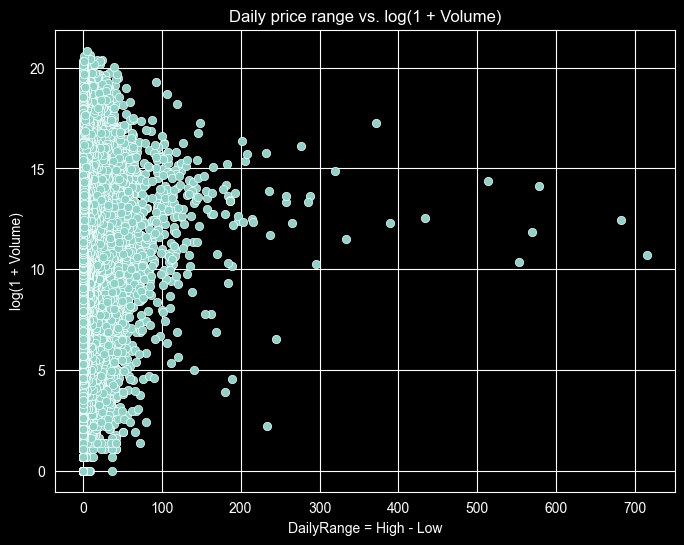

Correlation between DailyRange and log(1 + Volume): 0.12075917651930042


In [11]:

df["DailyRange"] =  df["high"] - df["low"]

df[["DailyRange", "volume"]].describe()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="DailyRange",
    y=np.log1p(df["volume"])
)
plt.title("Daily price range vs. log(1 + Volume)")
plt.xlabel("DailyRange = High - Low")
plt.ylabel("log(1 + Volume)")
plt.show()

corr = df["DailyRange"].corr(np.log1p(df["volume"]))
print("Correlation between DailyRange and log(1 + Volume):", corr)


Close price range per company

This code groups the data by company ticker, computes the minimum and maximum Close for each company, then derives a Close_range = max(Close) - min(Close) and plots a histogram of these ranges to show how widely closing prices move across different companies.

Summary of Close price ranges across tickers:


count    4849.000000
mean       63.320505
std        76.466975
min         0.000000
25%        14.430000
50%        32.930000
75%        78.559998
max       428.872410
Name: Close_range, dtype: float64

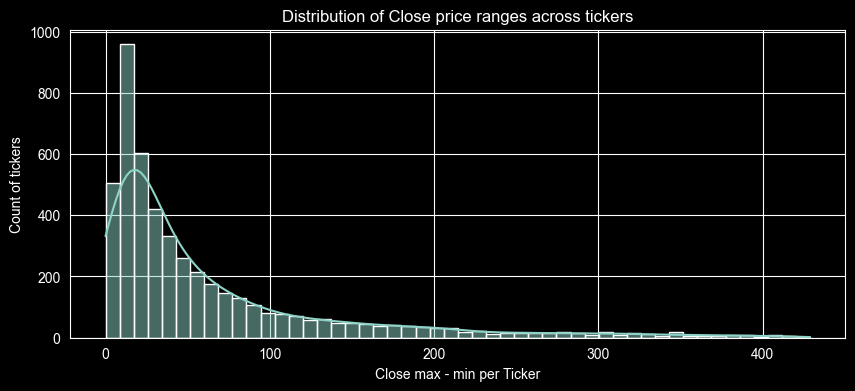

In [13]:
price_cols = ["open", "high", "low", "close"]

price_ranges = (
    df
    .groupby("ticker")[price_cols]
    .agg(["min", "max"])
)

price_ranges["Close_range"] = (
    price_ranges["close"]["max"] - price_ranges["close"]["min"]
)

print("Summary of Close price ranges across tickers:")
display(price_ranges["Close_range"].describe())

plt.figure(figsize=(10, 4))
sns.histplot(price_ranges["Close_range"], bins=50, kde=True)
plt.title("Distribution of Close price ranges across tickers")
plt.xlabel("Close max - min per Ticker")
plt.ylabel("Count of tickers")
plt.show()


In [5]:
def count_return_outliers_iqr_on_existing_return(
    df: pd.DataFrame,
    iqr_factor: float = 1.5
) -> tuple[pd.DataFrame, pd.DataFrame]:
    df = df.copy()
    df = df.sort_values(["ticker", "date"])

    def mark_outliers(group: pd.DataFrame) -> pd.DataFrame:
        g = group.copy()
        valid = g["return"].dropna()
        if valid.empty:
            g["return_is_outlier"] = False
            return g

        q1 = valid.quantile(0.25)
        q3 = valid.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_factor * iqr
        upper = q3 + iqr_factor * iqr

        g["return_is_outlier"] = (g["return"] < lower) | (g["return"] > upper)
        g.loc[g["return"].isna(), "return_is_outlier"] = False

        return g

    df_returns = (
        df
        .groupby("ticker", group_keys=False)
        .apply(mark_outliers)
    )

    summary = (
        df_returns
        .groupby("ticker")
        .agg(
            n_rows=("return", "count"),
            n_outliers=("return_is_outlier", "sum"),
        )
    )
    summary["outliers_ratio"] = summary["n_outliers"] / summary["n_rows"] * 100

    return df_returns, summary

df_ret, summary = count_return_outliers_iqr_on_existing_return(df)

print(summary.head())
print("إجمالي القيم المتطرفة في العوائد:", int(summary["n_outliers"].sum()))
print("نسبة القيم المتطرفة في العوائد (%):",
      100 * summary["n_outliers"].sum() / summary["n_rows"].sum())


C:\Users\LENONO\AppData\Local\Temp\ipykernel_7740\1554035921.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(mark_outliers)


             n_rows  n_outliers  outliers_ratio
ticker                                         
ticker_1       3704         155        4.184665
ticker_10      3704         170        4.589633
ticker_100     3704         225        6.074514
ticker_1000    3704         197        5.318575
ticker_1001    3704         168        4.535637
إجمالي القيم المتطرفة في العوائد: 699158
نسبة القيم المتطرفة في العوائد (%): 5.700834180315204


In [5]:
zero_per_ticker = (
    df.assign(is_zero=(df["volume"] == 0))
      .groupby("ticker")["is_zero"]
      .mean() * 100
)
print(zero_per_ticker.sort_values(ascending=False).head(20))


ticker
ticker_4752    100.000000
ticker_2542     93.730623
ticker_4676     83.282675
ticker_2488     81.358713
ticker_4896     76.764706
ticker_2437     73.508883
ticker_4696     72.741680
ticker_2915     42.121616
ticker_381      38.542510
ticker_4891     38.352273
ticker_2442     37.714831
ticker_4756     36.785714
ticker_3286     36.504015
ticker_2596     34.844698
ticker_4873     34.584450
ticker_2479     33.016705
ticker_2167     31.902834
ticker_2185     31.794872
ticker_4675     30.652504
ticker_2264     30.277244
Name: is_zero, dtype: float64


C:\Users\LENONO\AppData\Local\Temp\ipykernel_7740\4162574841.py:74: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(mark_outliers_enhanced)


📊 ملخص القيم المتطرفة
إجمالي القيم المتطرفة: 699,158
النسبة الإجمالية: 5.70%
عدد الأسهم المتأثرة: 4925
متوسط النسبة لكل سهم: 5.98%

💾 تم حفظ الرسوم في: outliers_analysis_overview.png


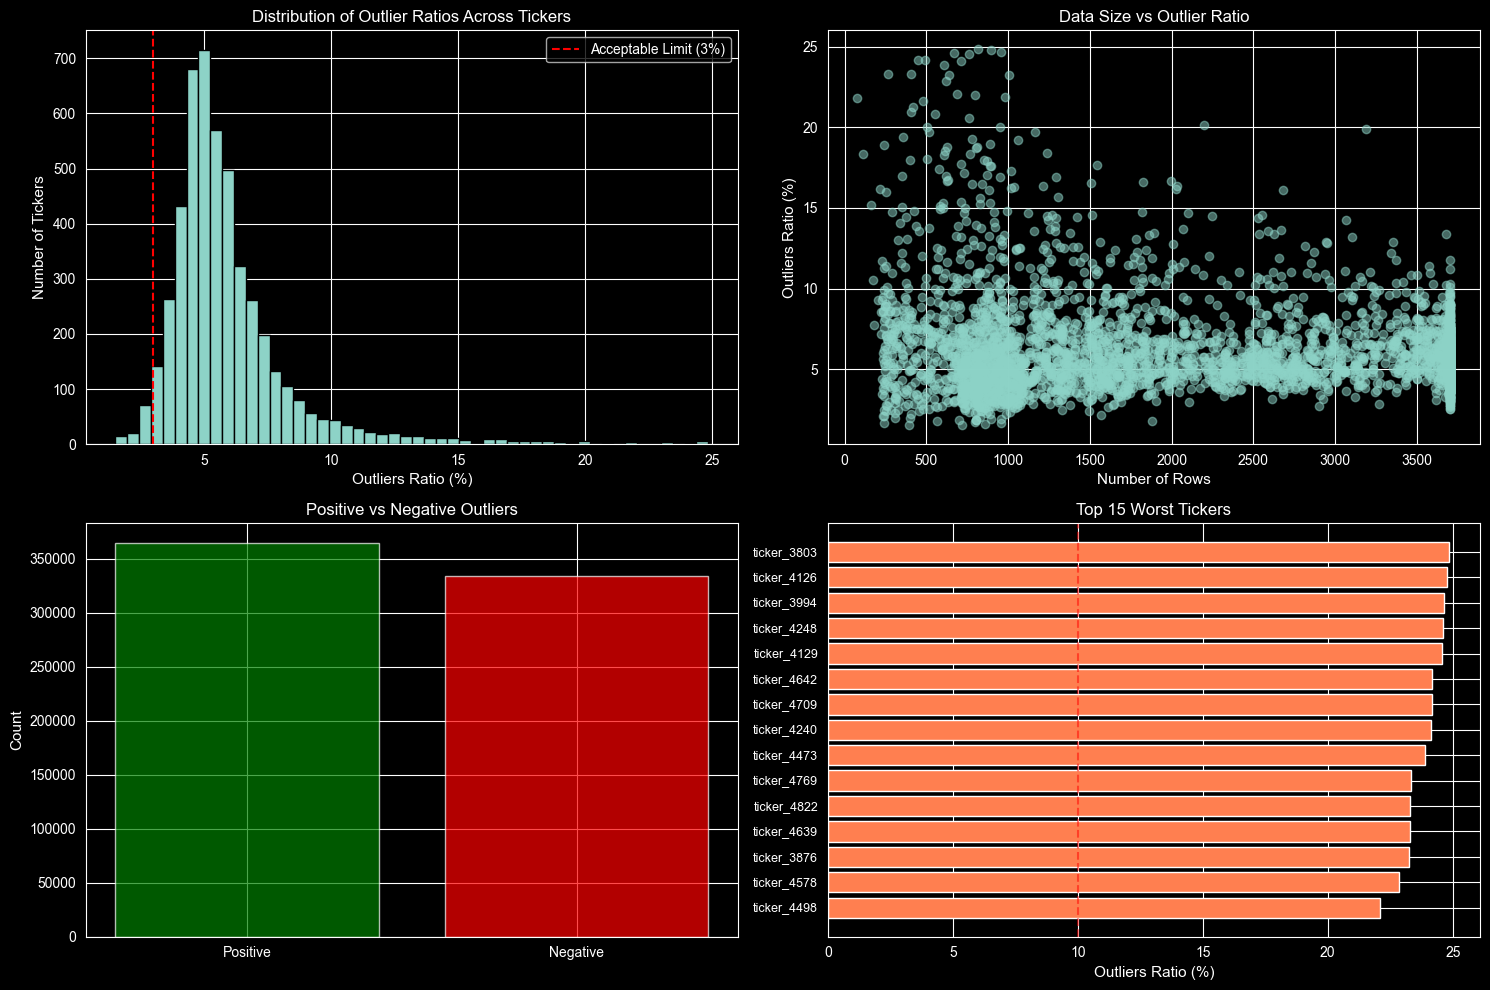


🔍 فحص تفصيلي للسهم: ticker_3803
إجمالي الصفوف: 818
عدد القيم المتطرفة: 203
النسبة: 24.82%

أكثر 15 قيمة تطرفاً:
               date      close    return  return_abs      outlier_type  \
8924193  2024-07-22   3.984000  0.556250    0.556250  extreme_positive   
8924084  2024-02-13  15.680000  0.555556    0.555556  extreme_positive   
8924045  2023-12-15  54.857143  0.446873    0.446873  extreme_positive   
8924050  2023-12-22  26.857143 -0.439542    0.439542  extreme_negative   
8924102  2024-03-11   9.200000  0.437500    0.437500  extreme_positive   
8924047  2023-12-19  61.571430  0.389426    0.389426  extreme_positive   
8924043  2023-12-13  38.000000 -0.352483    0.352483  extreme_negative   
8924085  2024-02-14  10.400000 -0.336735    0.336735  extreme_negative   
8924066  2024-01-18   7.840000 -0.304965    0.304965  extreme_negative   
8924083  2024-02-12  10.080000  0.304348    0.304348  extreme_positive   
8924202  2024-08-02   3.440000  0.303030    0.303030  extreme_positive   

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_return_outliers_deep(
    df: pd.DataFrame,
    price_col: str = "close",
    iqr_factor: float = 1.5,
    save_samples: bool = True
) -> dict:
    """
    تحليل شامل للقيم المتطرفة مع استخراج عينات للفحص اليدوي
    """

    df = df.copy()
    df = df.sort_values(["ticker", "date"])

    # حساب العوائد
    df["return"] = (
        df.groupby("ticker")[price_col]
        .pct_change()
    )

    # حساب العوائد المطلقة
    df["return_abs"] = df["return"].abs()

    # إضافة معلومات سياقية مهمة
    df["price_change"] = df.groupby("ticker")[price_col].diff()
    df["price_change_pct"] = df["price_change"] / df.groupby("ticker")[price_col].shift(1) * 100

    def mark_outliers_enhanced(group: pd.DataFrame) -> pd.DataFrame:
        g = group.copy()
        valid = g["return"].dropna()

        if valid.empty:
            g["return_is_outlier"] = False
            g["outlier_type"] = "none"
            g["distance_from_bounds"] = 0.0
            return g

        # حساب الحدود
        q1 = valid.quantile(0.25)
        q3 = valid.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - iqr_factor * iqr
        upper = q3 + iqr_factor * iqr

        # تمييز نوع القيمة المتطرفة
        g["return_is_outlier"] = (g["return"] < lower) | (g["return"] > upper)

        # تصنيف نوع القيمة المتطرفة
        g["outlier_type"] = "normal"
        g.loc[g["return"] > upper, "outlier_type"] = "extreme_positive"
        g.loc[g["return"] < lower, "outlier_type"] = "extreme_negative"
        g.loc[g["return"].isna(), "outlier_type"] = "missing"

        # حساب "بُعد" القيمة عن الحدود
        g["distance_from_bounds"] = 0.0
        g.loc[g["return"] > upper, "distance_from_bounds"] = g["return"] - upper
        g.loc[g["return"] < lower, "distance_from_bounds"] = lower - g["return"]

        # إضافة معلومات إحصائية للسهم
        g["ticker_mean_return"] = valid.mean()
        g["ticker_std_return"] = valid.std()
        g["ticker_volatility"] = valid.std() * np.sqrt(252)  # annualized

        return g

    # تطبيق التحليل
    df_analyzed = (
        df
        .groupby("ticker", group_keys=False)
        .apply(mark_outliers_enhanced)
    )

    # إضافة الأسعار السابقة واللاحقة (بعد التحليل)
    df_analyzed["prev_close"] = (
        df_analyzed
        .groupby("ticker")[price_col]
        .shift(1)
    )

    df_analyzed["next_close"] = (
        df_analyzed
        .groupby("ticker")[price_col]
        .shift(-1)
    )

    # ================================
    # 1. ملخص لكل سهم
    # ================================
    summary_by_ticker = (
        df_analyzed
        .groupby("ticker")
        .agg(
            n_rows=("return", "count"),
            n_outliers=("return_is_outlier", "sum"),
            n_extreme_pos=("outlier_type", lambda x: (x == "extreme_positive").sum()),
            n_extreme_neg=("outlier_type", lambda x: (x == "extreme_negative").sum()),
            max_return=("return", "max"),
            min_return=("return", "min"),
            mean_return=("return", "mean"),
            std_return=("return", "std"),
            max_distance=("distance_from_bounds", "max"),
        )
    )
    summary_by_ticker["outliers_ratio"] = (
        summary_by_ticker["n_outliers"] / summary_by_ticker["n_rows"] * 100
    )

    # ترتيب حسب نسبة القيم المتطرفة
    summary_by_ticker = summary_by_ticker.sort_values("outliers_ratio", ascending=False)

    # ================================
    # 2. استخراج القيم المتطرفة (بعد إضافة prev/next)
    # ================================
    outliers_only = df_analyzed[df_analyzed["return_is_outlier"] == True].copy()

    if len(outliers_only) > 0:
        # أخذ عينة عشوائية
        sample_size = min(200, len(outliers_only))
        outlier_samples = outliers_only.sample(n=sample_size, random_state=42)

        # ترتيب حسب الأهمية
        outlier_samples = outlier_samples.sort_values("distance_from_bounds", ascending=False)

    else:
        outlier_samples = pd.DataFrame()

    # ================================
    # 3. الحالات الأكثر تطرفاً
    # ================================
    if len(outliers_only) > 0:
        extreme_cases = (
            outliers_only
            .nlargest(50, "distance_from_bounds")
            [["ticker", "date", price_col, "return", "return_abs",
              "outlier_type", "distance_from_bounds", "volume",
              "ticker_volatility", "prev_close", "next_close"]]
        )
    else:
        extreme_cases = pd.DataFrame()

    # ================================
    # 4. تحليل زمني
    # ================================
    if "date" in df_analyzed.columns and len(outliers_only) > 0:
        df_temp = df_analyzed.copy()
        df_temp["year"] = pd.to_datetime(df_temp["date"]).dt.year
        df_temp["month"] = pd.to_datetime(df_temp["date"]).dt.month

        temporal_analysis = (
            df_temp[df_temp["return_is_outlier"] == True]
            .groupby("year")
            .size()
            .reset_index(name="n_outliers_per_year")
        )
    else:
        temporal_analysis = pd.DataFrame()

    # ================================
    # 5. إحصائيات عامة
    # ================================
    total_outliers = summary_by_ticker["n_outliers"].sum()
    total_rows = summary_by_ticker["n_rows"].sum()
    overall_ratio = (total_outliers / total_rows * 100) if total_rows > 0 else 0

    print("=" * 70)
    print("📊 ملخص القيم المتطرفة")
    print("=" * 70)
    print(f"إجمالي القيم المتطرفة: {int(total_outliers):,}")
    print(f"النسبة الإجمالية: {overall_ratio:.2f}%")
    print(f"عدد الأسهم المتأثرة: {len(summary_by_ticker)}")
    print(f"متوسط النسبة لكل سهم: {summary_by_ticker['outliers_ratio'].mean():.2f}%")
    print()

    return {
        "df_with_outliers": df_analyzed,
        "summary_by_ticker": summary_by_ticker,
        "outlier_samples": outlier_samples,
        "extreme_cases": extreme_cases,
        "temporal_analysis": temporal_analysis,
        "overall_stats": {
            "total_outliers": int(total_outliers),
            "total_rows": int(total_rows),
            "ratio": overall_ratio
        }
    }


# ================================
# دوال مساعدة للتحليل المرئي
# ================================

def visualize_outlier_distribution(results: dict):
    """رسوم بيانية لفهم توزيع القيم المتطرفة"""

    summary = results["summary_by_ticker"]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. توزيع نسبة القيم المتطرفة
    axes[0, 0].hist(summary["outliers_ratio"], bins=50, edgecolor="black")
    axes[0, 0].set_xlabel("Outliers Ratio (%)", fontsize=11)
    axes[0, 0].set_ylabel("Number of Tickers", fontsize=11)
    axes[0, 0].set_title("Distribution of Outlier Ratios Across Tickers", fontsize=12)
    axes[0, 0].axvline(3, color='red', linestyle='--', label='Acceptable Limit (3%)')
    axes[0, 0].legend()

    # 2. العلاقة بين حجم البيانات والقيم المتطرفة
    axes[0, 1].scatter(summary["n_rows"], summary["outliers_ratio"], alpha=0.5)
    axes[0, 1].set_xlabel("Number of Rows", fontsize=11)
    axes[0, 1].set_ylabel("Outliers Ratio (%)", fontsize=11)
    axes[0, 1].set_title("Data Size vs Outlier Ratio", fontsize=12)

    # 3. موجب vs سالب
    axes[1, 0].bar(["Positive", "Negative"],
                   [summary["n_extreme_pos"].sum(), summary["n_extreme_neg"].sum()],
                   color=['green', 'red'], alpha=0.7)
    axes[1, 0].set_ylabel("Count", fontsize=11)
    axes[1, 0].set_title("Positive vs Negative Outliers", fontsize=12)

    # 4. أسوأ 15 سهم
    top15 = summary.head(15).sort_values("outliers_ratio")
    axes[1, 1].barh(range(len(top15)), top15["outliers_ratio"], color='coral')
    axes[1, 1].set_yticks(range(len(top15)))
    axes[1, 1].set_yticklabels(top15.index, fontsize=9)
    axes[1, 1].set_xlabel("Outliers Ratio (%)", fontsize=11)
    axes[1, 1].set_title("Top 15 Worst Tickers", fontsize=12)
    axes[1, 1].axvline(10, color='red', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()


def inspect_ticker_outliers(df_analyzed: pd.DataFrame, ticker: str, n_show: int = 10):
    """فحص تفصيلي لقيم متطرفة لسهم معين"""

    ticker_data = df_analyzed[df_analyzed["ticker"] == ticker].copy()
    outliers = ticker_data[ticker_data["return_is_outlier"] == True]

    print(f"\n{'='*70}")
    print(f"🔍 فحص تفصيلي للسهم: {ticker}")
    print(f"{'='*70}")
    print(f"إجمالي الصفوف: {len(ticker_data)}")
    print(f"عدد القيم المتطرفة: {len(outliers)}")
    print(f"النسبة: {len(outliers)/len(ticker_data)*100:.2f}%")
    print()

    if len(outliers) > 0:
        print(f"أكثر {min(n_show, len(outliers))} قيمة تطرفاً:")
        cols_to_show = ["date", "close", "return", "return_abs", "outlier_type", "volume"]
        cols_available = [c for c in cols_to_show if c in outliers.columns]
        print(outliers.nlargest(n_show, "distance_from_bounds")[cols_available])
    else:
        print("✅ لا توجد قيم متطرفة لهذا السهم")

    print(f"{'='*70}\n")


# ================================
# الاستخدام
# ================================

# تشغيل التحليل الشامل
results = analyze_return_outliers_deep(
    df,
    price_col="close",
    iqr_factor=1.5,  # جرب 2.5 أو 3 إذا كانت النسبة عالية جداً
    save_samples=True
)

# رسم التوزيعات
visualize_outlier_distribution(results)

# فحص أسوأ سهم بالتفصيل
if len(results["summary_by_ticker"]) > 0:
    worst_ticker = results["summary_by_ticker"].index[0]
    inspect_ticker_outliers(results["df_with_outliers"], worst_ticker, n_show=15)

    # فحص أفضل سهم (للمقارنة)
    best_ticker = results["summary_by_ticker"].index[-1]
    inspect_ticker_outliers(results["df_with_outliers"], best_ticker, n_show=5)

